<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

# Sections
* [Description](#0)
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Search for Spark Installation](#1.2)
  * [1.3 Create SparkSession](#1.3)
* [2. Lab](#2)
  * [2.1 Check Files](#2.1)
  * [2.2 Read RAW DataFrames](#2.3)
  * [2.3 Transform RAW DataFrames](#2.3)
  * [2.4 Write DataFrames to STD](#2.4)
  * [2.5 All at once](#2.5)
* [3. TearDown](#3)
  * [3.1 Stop Hadoop](#3.1)

<a id='0'></a>
## Description
<p>
<div>The goals for this lab are:</div>
<ul>    
    <li>Get familiar with Spark DataFrames API</li>
    <li>Apply some transformations using Spark DataFrames API</li>
    <li>Promote data from raw to std layer in the datalake using Spark DataFrames API</li>
</ul>    
</p>
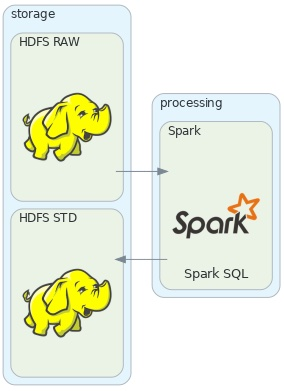

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
import findspark
findspark.init()

I'm changing pandas max column width property to improve data displaying

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession
By setting this environment variable we can include extra libraries in our Spark cluster

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = ' pyspark-shell'

The first thing always is to create the SparkSession

In [4]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
.appName("Movielens - Step 1 - RAW to STD")
.config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
.getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<a id='2'></a>
## 2. Lab

<a id='2.1'></a>
### 2.1 Check  Files

In order to complete this lab you need to previosly complete **'HDFS Lab Movielens'**.

Check you have the data ready in HDFS

http://localhost:50070/explorer.html#/datalake/raw/movielens

<a id='2.2'></a>
### 2.2 Read RAW DataFrames

In [5]:
movies_raw = (spark.read
              .option("header","true")
              .option("escape","\"")
              .csv("hdfs://localhost:9000/datalake/raw/movielens/movies/"))
movies_raw.limit(10).toPandas()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [6]:
movies_raw.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [7]:
ratings_raw = spark.read.option("header","true").csv("hdfs://localhost:9000/datalake/raw/movielens/ratings/")
ratings_raw.limit(10).toPandas()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [8]:
ratings_raw.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [9]:
links_raw = spark.read.option("header","true").csv("hdfs://localhost:9000/datalake/raw/movielens/links/")
links_raw.show(10,False)

+-------+-------+------+
|movieId|imdbId |tmdbId|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
|4      |0114885|31357 |
|5      |0113041|11862 |
|6      |0113277|949   |
|7      |0114319|11860 |
|8      |0112302|45325 |
|9      |0114576|9091  |
|10     |0113189|710   |
+-------+-------+------+
only showing top 10 rows



In [10]:
links_raw.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- imdbId: string (nullable = true)
 |-- tmdbId: string (nullable = true)



In [11]:
tags_raw = spark.read.option("header","true").csv("hdfs://localhost:9000/datalake/raw/movielens/tags/")
tags_raw.limit(10).toPandas()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
5,2,89774,Tom Hardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,Leonardo DiCaprio,1445715051
8,2,106782,Martin Scorsese,1445715056
9,7,48516,way too long,1169687325


In [12]:
tags_raw.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [13]:
trailers_raw = spark.read.option("header","true").csv("hdfs://localhost:9000/datalake/raw/movielens/trailers/")
trailers_raw.limit(10).show(truncate=False)

+-----------+-------+----------------------------------+
|youtubeId  |movieId|title                             |
+-----------+-------+----------------------------------+
|K26_sDKnvMU|1      |Toy Story (1995)                  |
|3LPANjHlPxo|2      |Jumanji (1995)                    |
|rEnOoWs3FuA|3      |Grumpier Old Men (1995)           |
|j9xml1CxgXI|4      |Waiting to Exhale (1995)          |
|ltwvKLnj1B4|5      |Father of the Bride Part II (1995)|
|2GfZl4kuVNI|6      |Heat (1995)                       |
|twTksx_lWB4|7      |Sabrina (1995)                    |
|-C-xXZyX2zU|8      |Tom and Huck (1995)               |
|SCOxEKkuWG4|9      |Sudden Death (1995)               |
|lcOqUE0u1LM|10     |GoldenEye (1995)                  |
+-----------+-------+----------------------------------+



In [14]:
trailers_raw.printSchema()

root
 |-- youtubeId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)



<a id='2.3'></a>
### 2.3 Transform RAW DataFrames

In [15]:
from pyspark.sql.functions import *

@udf("array<string>")
def parse_title(t:str):
    import re
    titleRegex = re.compile(r'^(.+)\((\d{4})\)$')
    m = titleRegex.search(t.strip())
    if m:
        title,year= m.groups()
        return [title.strip(),year.strip()]
    else:
        return [t,None]
    


movies_std = movies_raw.select(
    col("movieId").cast("bigint"),
    parse_title(col("title"))[0].alias("title"),
    parse_title(col("title"))[1].cast("integer").alias("year"),
    split("genres","\|").alias("genres")
    )

movies_std.toPandas()

,movieId,title,year,genres
0,1,Toy Story,1995.0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji,1995.0,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men,1995.0,"[Comedy, Romance]"
3,4,Waiting to Exhale,1995.0,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,1995.0,[Comedy]
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,2017.0,"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero,2017.0,"[Animation, Comedy, Fantasy]"
9739,193585,Flint,2017.0,[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple,2018.0,"[Action, Animation]"


In [18]:
movies_std.printSchema()

root
 |-- movieId: long (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [22]:
# there are some problems
#movies_std.where(col("year").isNull()).toPandas()
movies_std = movies_std.withColumn("genres",array_remove(col("genres"),"(no genres listed)"))
#movies_std.where(col("year").isNull()).toPandas()

,movieId,title,year,genres
0,40697,Babylon 5,NaN,[Sci-Fi]
1,140956,Ready Player One,NaN,"[Action, Sci-Fi, Thriller]"
2,143410,Hyena Road,NaN,[]
3,147250,The Adventures of Sherlock Holmes and Doctor Watson,NaN,[]
4,149334,Nocturnal Animals,NaN,"[Drama, Thriller]"
5,156605,Paterson,NaN,[]
6,162414,Moonlight,NaN,[Drama]
7,167570,The OA,NaN,[]
8,171495,Cosmos,NaN,[]
9,171631,Maria Bamford: Old Baby,NaN,[]


In [23]:
movies_std.printSchema()

root
 |-- movieId: long (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [24]:
from pyspark.sql.functions import *
ratings_std = ratings_raw.select(
    col("userId").cast("bigint"),
    col("movieId").cast("bigint"),
    col("rating").cast("double"),    
    to_timestamp(from_unixtime("timestamp")).alias("timestamp")
).withColumn("year",year("timestamp"))
ratings_std.toPandas()

,userId,movieId,rating,timestamp,year
0,1,1,4.0,2000-07-30 20:45:03,2000
1,1,3,4.0,2000-07-30 20:20:47,2000
2,1,6,4.0,2000-07-30 20:37:04,2000
3,1,47,5.0,2000-07-30 21:03:35,2000
4,1,50,5.0,2000-07-30 20:48:51,2000
...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 23:53:22,2017
100832,610,168248,5.0,2017-05-04 00:21:31,2017
100833,610,168250,5.0,2017-05-08 21:50:47,2017
100834,610,168252,5.0,2017-05-03 23:19:12,2017


In [26]:
ratings_std.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- year: integer (nullable = true)



In [27]:
from pyspark.sql.functions import *

links_std = links_raw.select(
    col("movieId").cast("bigint"),
    col("imdbId"),    
    concat(lit("http://www.imdb.com/title/tt"),col("imdbId"),lit("/")).alias("imdbUrl"),
    col("tmdbId"),    
    concat(lit("https://www.themoviedb.org/movie/"),col("imdbId"),lit("/")).alias("tmdbUrl")
)
links_std.toPandas()

,movieId,imdbId,imdbUrl,tmdbId,tmdbUrl
0,1,0114709,http://www.imdb.com/title/tt0114709/,862,https://www.themoviedb.org/movie/0114709/
1,2,0113497,http://www.imdb.com/title/tt0113497/,8844,https://www.themoviedb.org/movie/0113497/
2,3,0113228,http://www.imdb.com/title/tt0113228/,15602,https://www.themoviedb.org/movie/0113228/
3,4,0114885,http://www.imdb.com/title/tt0114885/,31357,https://www.themoviedb.org/movie/0114885/
4,5,0113041,http://www.imdb.com/title/tt0113041/,11862,https://www.themoviedb.org/movie/0113041/
...,...,...,...,...,...
9737,193581,5476944,http://www.imdb.com/title/tt5476944/,432131,https://www.themoviedb.org/movie/5476944/
9738,193583,5914996,http://www.imdb.com/title/tt5914996/,445030,https://www.themoviedb.org/movie/5914996/
9739,193585,6397426,http://www.imdb.com/title/tt6397426/,479308,https://www.themoviedb.org/movie/6397426/
9740,193587,8391976,http://www.imdb.com/title/tt8391976/,483455,https://www.themoviedb.org/movie/8391976/


In [28]:
links_std.printSchema()

root
 |-- movieId: long (nullable = true)
 |-- imdbId: string (nullable = true)
 |-- imdbUrl: string (nullable = true)
 |-- tmdbId: string (nullable = true)
 |-- tmdbUrl: string (nullable = true)



In [29]:
from pyspark.sql.functions import *

tags_std = tags_raw.select(
    col("userId").cast("bigint"),
    col("movieId").cast("bigint"),
    trim(lower("tag")).alias("tag"),
    to_timestamp(from_unixtime("timestamp")).alias("timestamp")
).withColumn("year",year("timestamp"))
tags_std.toPandas()

,userId,movieId,tag,timestamp,year
0,2,60756,funny,2015-10-24 21:29:54,2015
1,2,60756,highly quotable,2015-10-24 21:29:56,2015
2,2,60756,will ferrell,2015-10-24 21:29:52,2015
3,2,89774,boxing story,2015-10-24 21:33:27,2015
4,2,89774,mma,2015-10-24 21:33:20,2015
...,...,...,...,...,...
3678,606,7382,for katie,2007-02-11 23:46:59,2007
3679,606,7936,austere,2007-03-08 23:18:54,2007
3680,610,3265,gun fu,2017-05-03 22:39:44,2017
3681,610,3265,heroic bloodshed,2017-05-03 22:39:38,2017


In [30]:
tags_std.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- year: integer (nullable = true)



In [31]:
from pyspark.sql.functions import *

trailers_std = trailers_raw.select(
    col("movieId").cast("bigint"),
    col("youtubeId"),    
    concat(lit("https://www.youtube.com/embed/"),col("youtubeId"),lit("/")).alias("youtubeUrl")
)
trailers_std.toPandas()

,movieId,youtubeId,youtubeUrl
0,1,K26_sDKnvMU,https://www.youtube.com/embed/K26_sDKnvMU/
1,2,3LPANjHlPxo,https://www.youtube.com/embed/3LPANjHlPxo/
2,3,rEnOoWs3FuA,https://www.youtube.com/embed/rEnOoWs3FuA/
3,4,j9xml1CxgXI,https://www.youtube.com/embed/j9xml1CxgXI/
4,5,ltwvKLnj1B4,https://www.youtube.com/embed/ltwvKLnj1B4/
...,...,...,...
25618,131252,-oB6DN5dYWo,https://www.youtube.com/embed/-oB6DN5dYWo/
25619,131256,DK7KQ-gEdl4,https://www.youtube.com/embed/DK7KQ-gEdl4/
25620,131258,v29P-wchMZQ,https://www.youtube.com/embed/v29P-wchMZQ/
25621,131260,dAz-nZ65jYU,https://www.youtube.com/embed/dAz-nZ65jYU/


In [ ]:
trailers_std.printSchema()

<a id='2.4'></a>
### 2.4 Write DataFrames to STD

In [32]:
movies_std.write.mode("overwrite").parquet("hdfs://localhost:9000/datalake/std/movielens/movies/")

ratings_std.write.mode("overwrite").partitionBy("year").parquet("hdfs://localhost:9000/datalake/std/movielens/ratings/")

links_std.write.mode("overwrite").parquet("hdfs://localhost:9000/datalake/std/movielens/links/")

tags_std.write.mode("overwrite").partitionBy("year").parquet("hdfs://localhost:9000/datalake/std/movielens/tags/")

trailers_std.write.mode("overwrite").parquet("hdfs://localhost:9000/datalake/std/movielens/trailers/")

----------------------------------------                                        
Exception occurred during processing of request from ('127.0.0.1', 56048)
Traceback (most recent call last):
  File "/usr/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.9/socketserver.py", line 720, in __init__
    self.handle()
  File "/opt/spark3/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/opt/spark3/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/opt/spark3/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark3/python/pyspark/

<a id='2.5'></a>
### 2.5 All at once

Dividing your code in multiple cells is **NOT the way** you would do it for a production workload.<br/>
We've been using variables, printing schema and data (toPandas and show) just to check our transformations are correct<br/>
You would code the application like this:

In [ ]:
from pyspark.sql.functions import *

@udf("array<string>")
def parse_title(t:str):
    import re
    titleRegex = re.compile(r'^(.+)\((\d{4})\)$')
    m = titleRegex.search(t.strip())
    if m:
        title,year= m.groups()
        return [title.strip(),year.strip()]
    else:
        return [t,None]

#movies

(spark.read
     .option("header","true")
     .option("escape","\"")
     .csv("hdfs://localhost:9000/datalake/raw/movielens/movies/")
     .select(
        col("movieId").cast("bigint"),
        parse_title(col("title"))[0].alias("title"),
        parse_title(col("title"))[1].cast("integer").alias("year"),
        split("genres","\|").alias("genres")
      )
    .write
    .mode("overwrite")
    .parquet("hdfs://localhost:9000/datalake/std/movielens/movies/"))
  
# ratings
(spark.read
    .option("header","true")
    .csv("hdfs://localhost:9000/datalake/raw/movielens/ratings/")
    .select(
        col("userId").cast("bigint"),
        col("movieId").cast("bigint"),
        col("rating").cast("double"),    
        to_timestamp(from_unixtime("timestamp")).alias("timestamp")        
    )
    .withColumn("year",year("timestamp")) 
    .write
    .mode("overwrite")
    .partitionBy("year") 
    .parquet("hdfs://localhost:9000/datalake/std/movielens/ratings/"))


#links
(spark.read
     .option("header","true")
     .csv("hdfs://localhost:9000/datalake/raw/movielens/links/")
     .select(
        col("movieId").cast("bigint"),
        col("imdbId"),    
        concat(lit("http://www.imdb.com/title/tt"),col("imdbId"),lit("/")).alias("imdbUrl"),
        col("tmdbId"),    
        concat(lit("https://www.themoviedb.org/movie/"),col("imdbId"),lit("/")).alias("tmdbUrl"))
     .write
     .mode("overwrite")
     .parquet("hdfs://localhost:9000/datalake/std/movielens/links/"))

#tags
(spark.read
     .option("header","true")
     .csv("hdfs://localhost:9000/datalake/raw/movielens/tags/")
     .select(
        col("userId").cast("bigint"),
        col("movieId").cast("bigint"),
        trim(lower("tag")).alias("tag"),
        to_timestamp(from_unixtime("timestamp")).alias("timestamp")
     )
     .withColumn("year",year("timestamp"))
     .write
     .mode("overwrite")
     .partitionBy("year") 
     .parquet("hdfs://localhost:9000/datalake/std/movielens/tags/"))

#trailers
(spark.read
     .option("header","true")
     .csv("hdfs://localhost:9000/datalake/raw/movielens/trailers/")
     .select(
        col("movieId").cast("bigint"),
        col("youtubeId"),    
        concat(lit("https://www.youtube.com/embed/"),col("youtubeId"),lit("/")).alias("youtubeUrl"))
     .write
     .mode("overwrite")
     .parquet("hdfs://localhost:9000/datalake/std/movielens/trailers/"))

<a id='3'></a>
## 3. Tear Down

Once we complete the the lab we can stop all the services

<a id='3.1'></a>
### 3.1 Stop Hadoop

Stops Hadoop
Open a terminal and execute
```sh
hadoop-stop.sh
```